In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.tail()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [4]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [5]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
pd.options.display.max_rows = 222

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.100490,0.300653,0.0000,0.000000,0.00000,0.000000,1.0000
var_0,200000.0,10.679914,3.040051,0.4084,8.453850,10.52475,12.758200,20.3150
var_1,200000.0,-1.627622,4.050044,-15.0434,-4.740025,-1.60805,1.358625,10.3768
var_2,200000.0,10.715192,2.640894,2.1171,8.722475,10.58000,12.516700,19.3530
var_3,200000.0,6.796529,2.043319,-0.0402,5.254075,6.82500,8.324100,13.1883
var_4,200000.0,11.078333,1.623150,5.0748,9.883175,11.10825,12.261125,16.6714
var_5,200000.0,-5.065317,7.863267,-32.5626,-11.200350,-4.83315,0.924800,17.2516
var_6,200000.0,5.408949,0.866607,2.3473,4.767700,5.38510,6.003000,8.4477
var_7,200000.0,16.545850,3.418076,5.3497,13.943800,16.45680,19.102900,27.6918
var_8,200000.0,0.284162,3.332634,-10.5055,-2.317800,0.39370,2.937900,10.1513


In [9]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

Пропусков нет. Все данные числа

Сделать базовый анализ целевой переменной, сделать выводы;

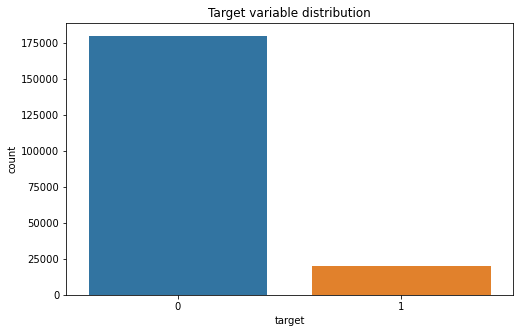

In [10]:
TARGET_NAME = 'target'

plt.figure(figsize=(8,5))

sns.countplot(x=TARGET_NAME,data=train)
plt.title('Target variable distribution')

plt.show()

Переменная распределена неравномерно. Дисбаланс классов.

Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

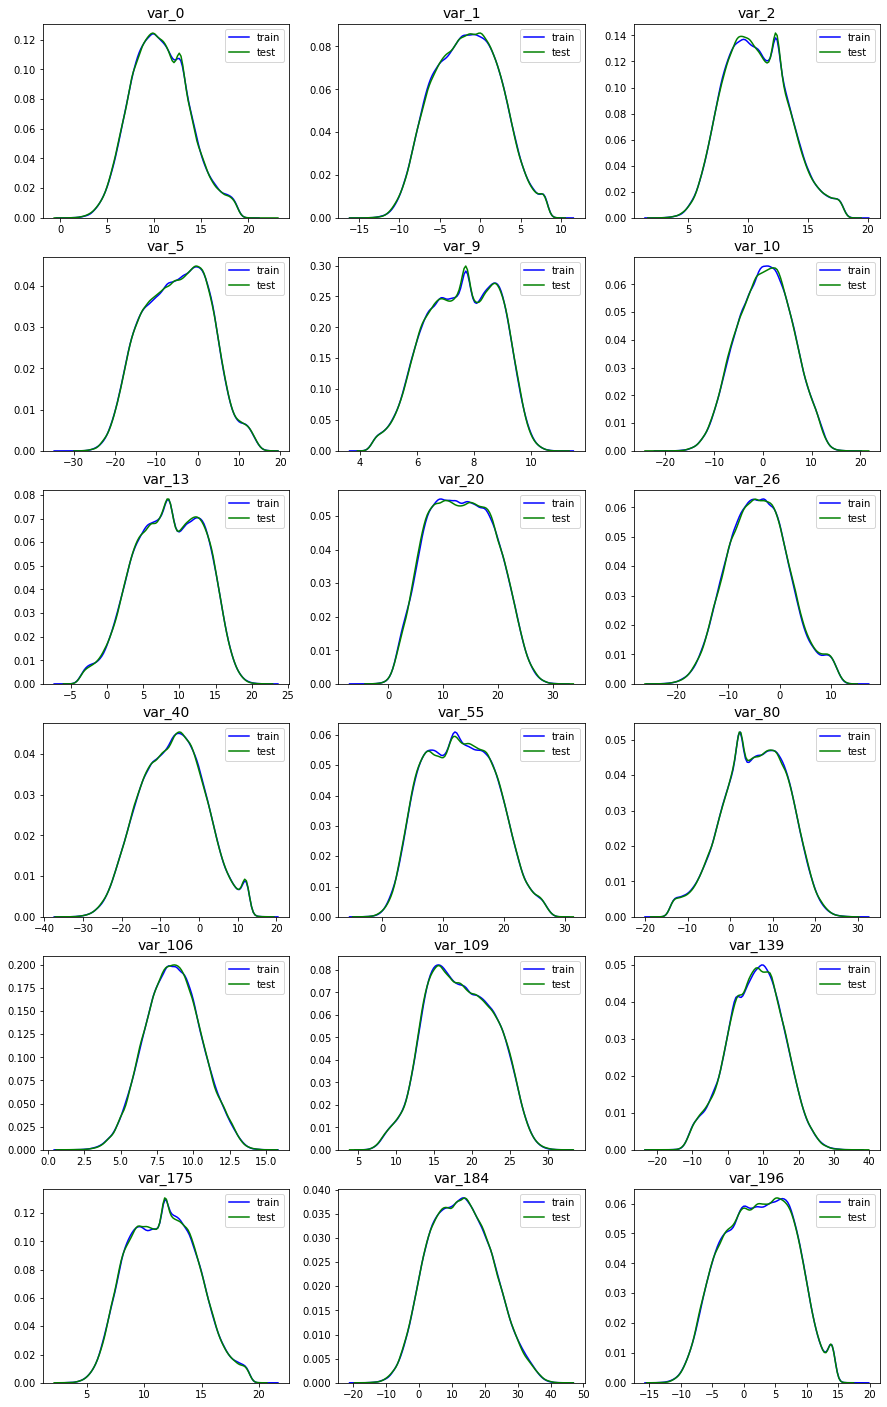

In [11]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25))

continuous_feature = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26',
                   'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']


#for num, feature in enumerate(continuous_feature):
#    data = train[feature].copy()
#    axes[num//3, num%3].hist(data, bins=25, color="blue")
#    axes[num//3, num%3].set_xlabel(feature, fontsize=14)
    
    

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
    axes[num//3, num%3].set_title(feature, fontsize=14)

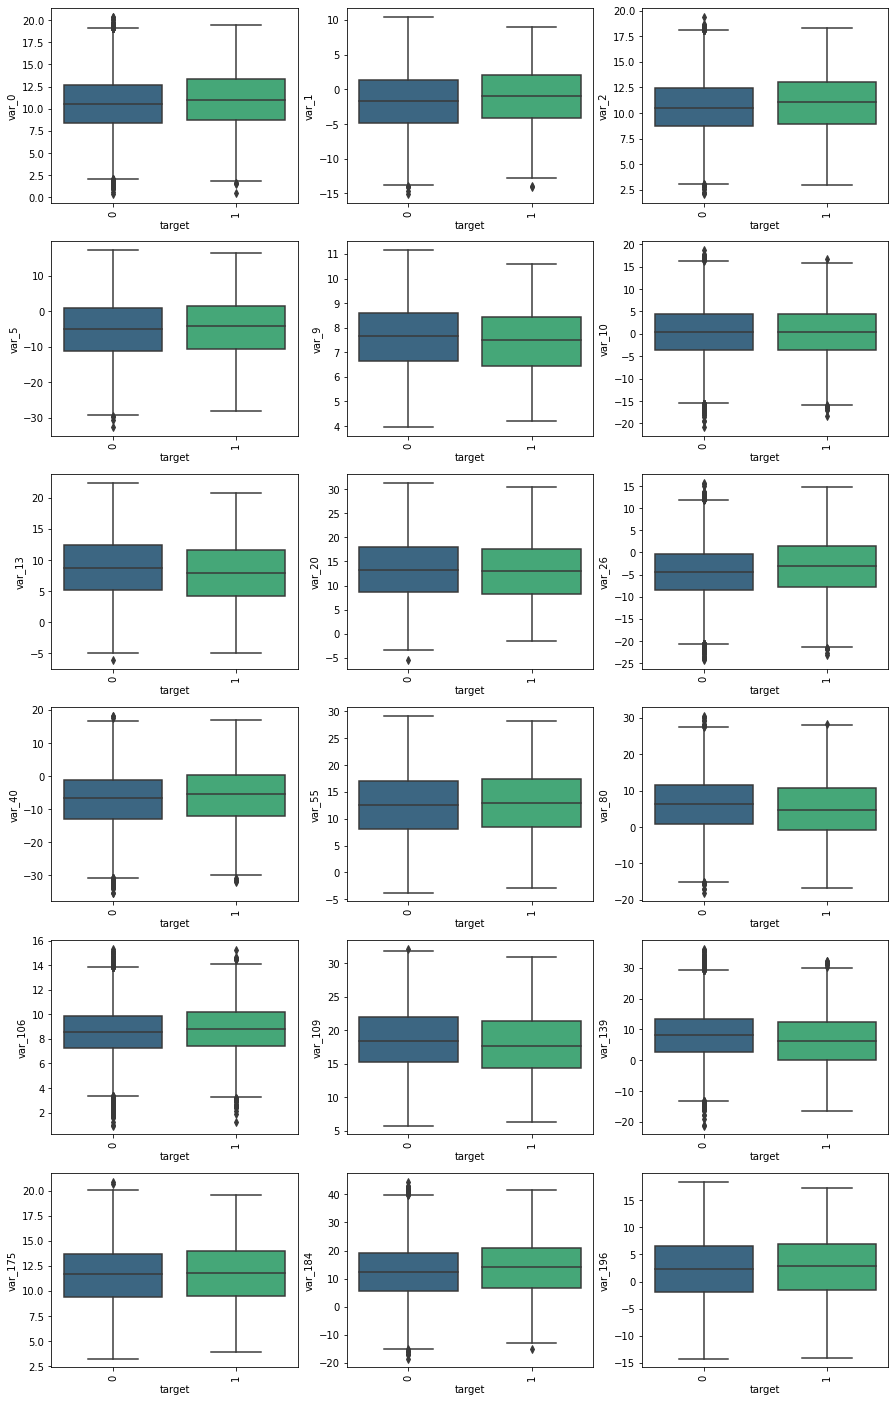

In [12]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25))
targert = train[TARGET_NAME].copy()

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    sns.boxplot(y=feature, x=TARGET_NAME, data=train, palette="viridis", ax=axes[num//3, num%3]) 
    axes[num//3, num%3].tick_params(axis="x", rotation=90)
    #axes[num//3, num%3].axis(ymin=0, ymax=40)

У тренировочной и тестовой одинаковое распределение. Но значение переменных лежат в одинаковых допускал для всех типов целевой переменной.

Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [13]:
df_stat_target1 = train.loc[train['target']==1, :].describe()
df_stat_target0 = train.loc[train['target']==0, :].describe()

In [14]:
for column in df_stat_target1.columns:
    print(column)
    print(f"{df_stat_target1[column]['mean']}   {df_stat_target0[column]['mean']}")
    print(f"{df_stat_target1[column]['std']}   {df_stat_target0[column]['std']}")

target
1.0   0.0
0.0   0.0
var_0
11.156418036620618   10.626680974641955
3.2702931012262617   3.008563521297741
var_1
-1.017612832122605   -1.695769670153749
4.220637674232161   4.024812721033304
var_2
11.15663305304011   10.665875638403172
2.841075366614294   2.6129614947393636
var_3
6.864113205294029   6.788978911852031
2.070898146479751   2.0400816198201848
var_4
11.131337207682348   11.072411829218156
1.6492658551260049   1.6201027392269212
var_5
-4.336522022091762   -5.146735884537117
8.140280783879794   7.827521949174242
var_6
5.5819659468603815   5.389619819123737
0.9224419947073852   0.8579833911188673
var_7
16.51491702159419   16.549305597492147
3.4213650094423462   3.4177000306536596
var_8
0.4794318190864758   0.26234699614234147
3.3400277268096374   3.331105012449328
var_9
7.409063633197311   7.584906845949397
1.2787091641958552   1.228838585278674
var_10
0.35791563837197765   0.39840968805238336
5.515060482098519   5.499197178981993
var_11
-2.8348884018310256   -3.291478864

отличий почти нет

In [15]:
df_stat_train = train.describe()
df_stat_test = test.describe()

In [16]:
for column in df_stat_test.columns:
    print(column)
    print(f"{df_stat_train[column]['mean']}   {df_stat_test[column]['mean']}")
    print(f"{df_stat_train[column]['std']}   {df_stat_test[column]['std']}")

var_0
10.67991425200015   10.658737106499814
3.040050870668801   3.0367155808198913
var_1
-1.6276216894999924   -1.6242437800000011
4.050044189955011   4.040509145134395
var_2
10.715191851000073   10.707451979500098
2.640894191799927   2.633888454459103
var_3
6.796529157000018   6.788213908500028
2.0433190163597184   2.0527236594148444
var_4
11.078333240500118   11.076399133000201
1.6231495339368662   1.6164562020249658
var_5
-5.065317493499968   -5.05055772899984
7.863266683476754   7.86929301037157
var_6
5.408948681499958   5.415164112499948
0.8666072662169084   0.8646861316394268
var_7
16.545849889500108   16.529142737500187
3.418075578937139   3.4244818156142665
var_8
0.2841618499999962   0.27713482600000455
3.332633536717585   3.3333749336096177
var_9
7.567236361499921   7.569407457999987
1.235069925299941   1.2318654731380745
var_10
0.39434044100000565   0.3713349949999954
5.500793007191889   5.508661267539324
var_11
-3.24559608850003   -3.2685512850000973
5.970253095505347   5.9

Одинаково

Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [17]:
cor = train.corr()

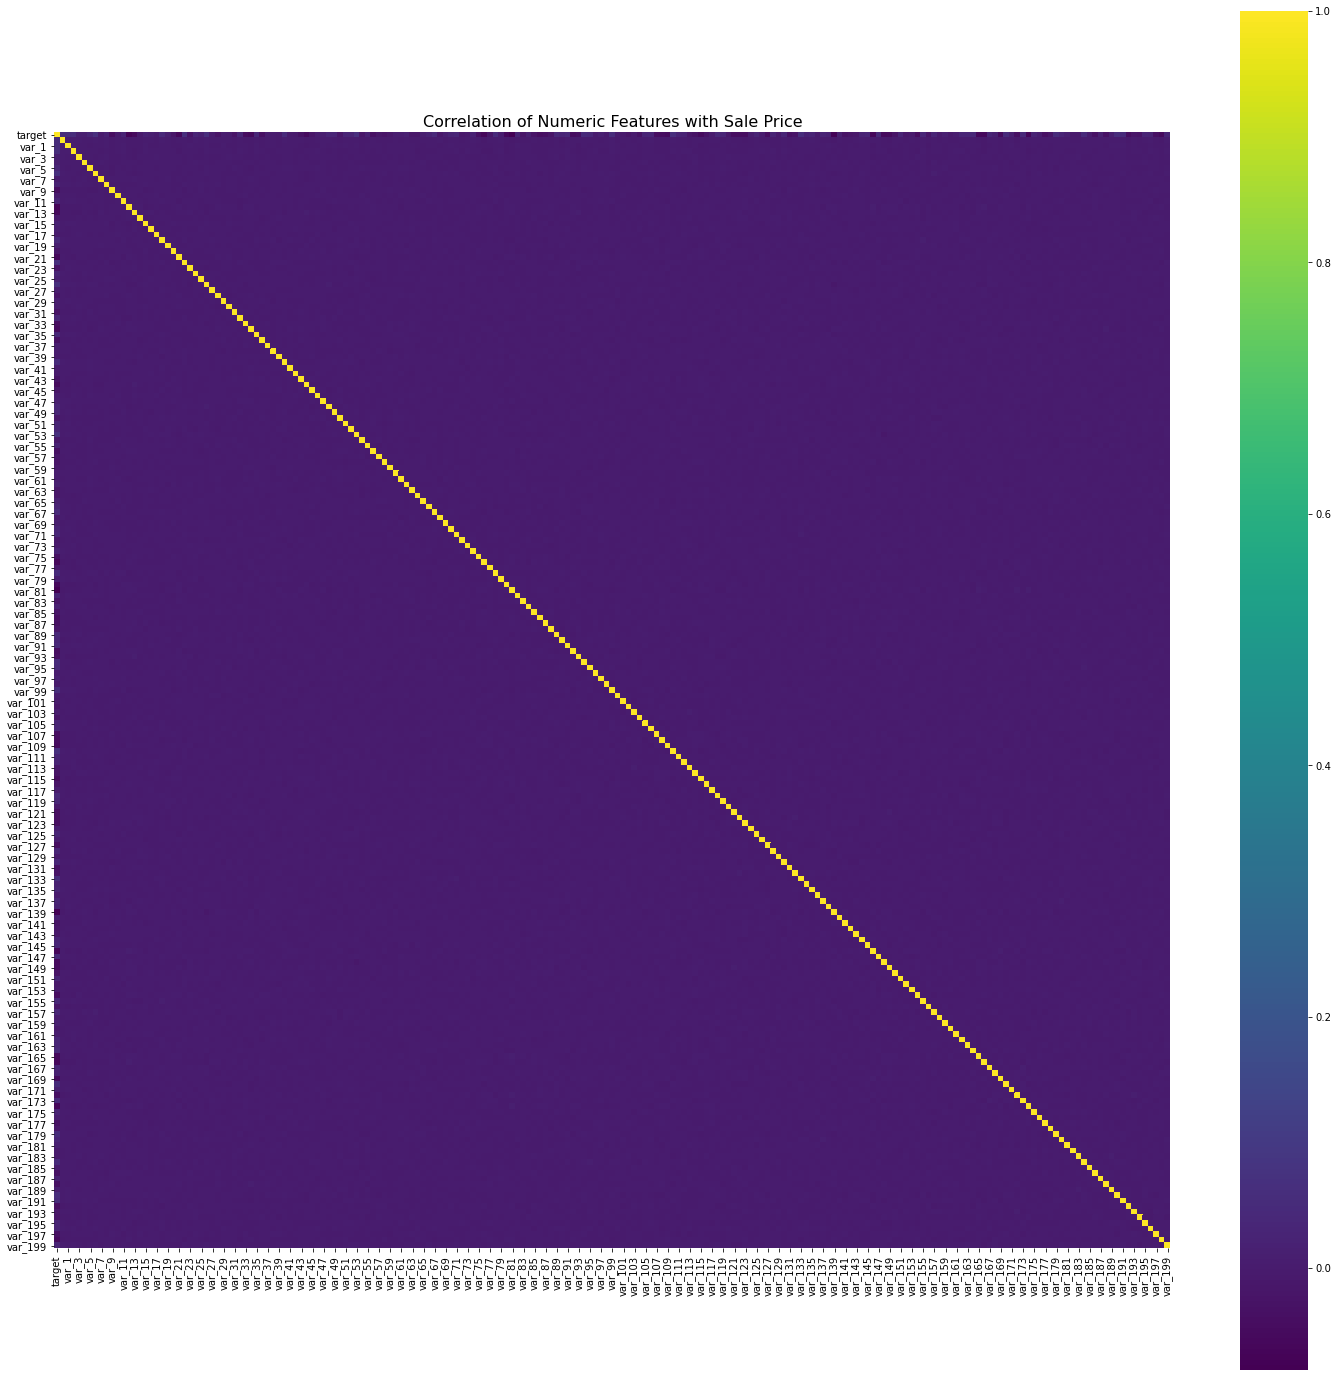

In [18]:
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

Данные не коррелируют

Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [19]:
cor = cor.loc[cor.index==TARGET_NAME,  cor.columns != TARGET_NAME]
cor

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,0.05239,0.050343,0.05587,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,-0.042805,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053,0.025434


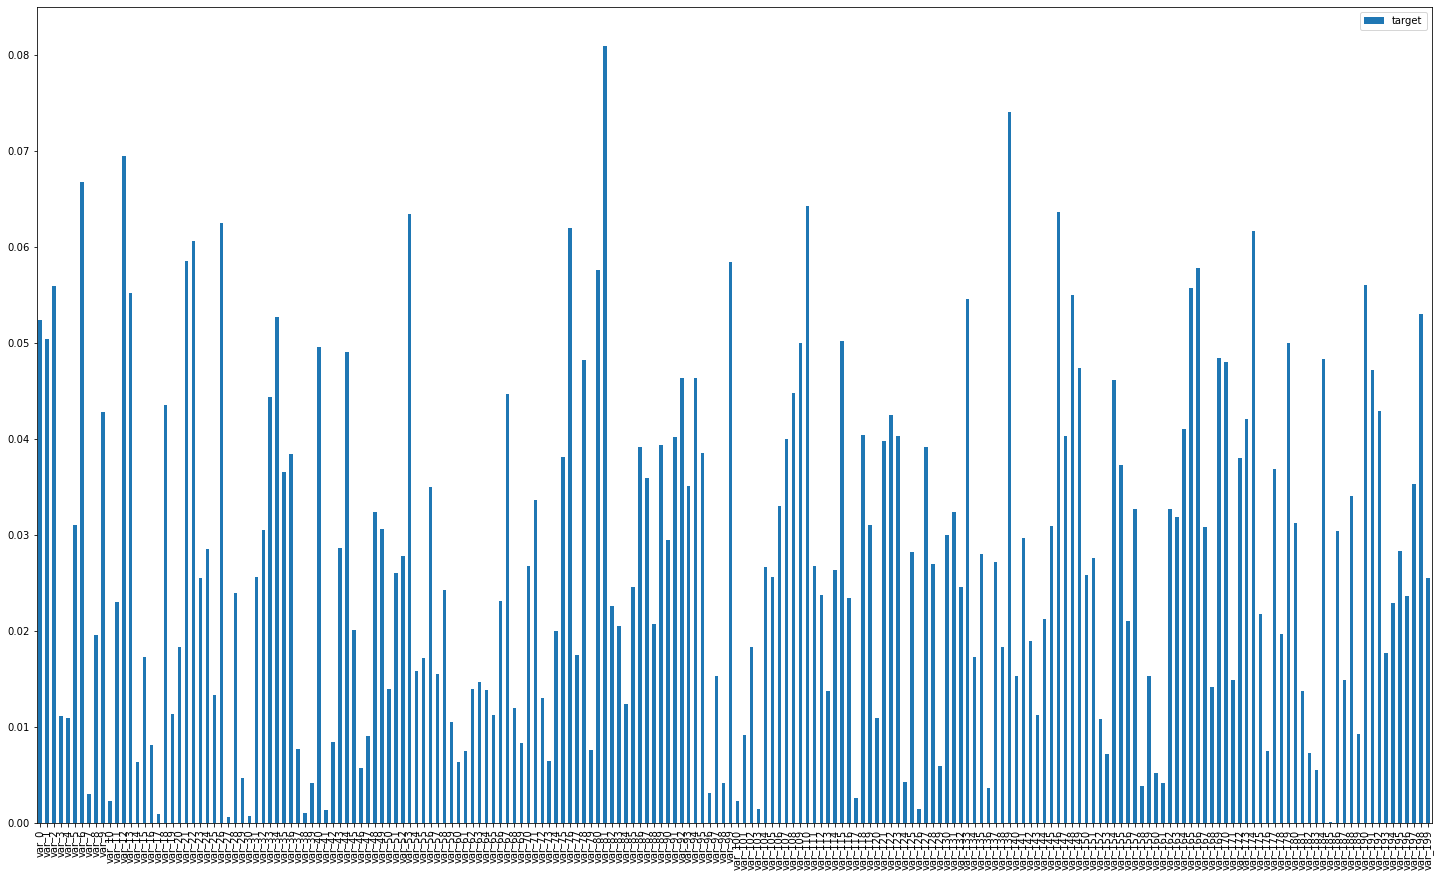

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 15
cor.T.abs().plot(kind='bar')
plt.show()

In [21]:
cor = cor.T.abs()
cor = cor.sort_values(TARGET_NAME, ascending=False)
index_cor = cor.index
index_cor

Index(['var_81', 'var_139', 'var_12', 'var_6', 'var_110', 'var_146', 'var_53',
       'var_26', 'var_76', 'var_174',
       ...
       'var_100', 'var_10', 'var_103', 'var_126', 'var_41', 'var_38', 'var_17',
       'var_30', 'var_27', 'var_185'],
      dtype='object', length=200)

 Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [22]:
from sklearn.ensemble import RandomForestClassifier

X_train = train.copy()
X_train = X_train.drop(['ID_code', 'target'], axis=1)
col = X_train.columns
y_train = train['target'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=24)

model_RFR = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=24)
model_RFR.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=24)

In [23]:
pred = model_RFR.predict(X_test)

from sklearn.metrics import accuracy_score

print(f'accuracy {accuracy_score(y_test, pred)}')

accuracy 0.89962


In [24]:
feature_important = model_RFR.feature_importances_
#feature_important_df = pd.DataFrame(data=feature_important.reshape(1,200), columns=col, index=["data"])
feature_important_df = pd.DataFrame(data=feature_important, columns=['impotant'], index=col)
feature_important_df

,impotant
var_0,0.007372
var_1,0.007778
var_2,0.008599
var_3,0.002518
var_4,0.002413
var_5,0.004857
var_6,0.014915
var_7,0.002137
var_8,0.002075
var_9,0.006180


In [25]:
feature_important_df = feature_important_df.sort_values('impotant', ascending=False)
feature_important_df.head(10)

,impotant
var_81,0.038097
var_12,0.027968
var_139,0.026402
var_110,0.017760
var_53,0.016528
var_174,0.015845
var_26,0.015121
var_22,0.015057
var_6,0.014915
var_166,0.014610


 Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

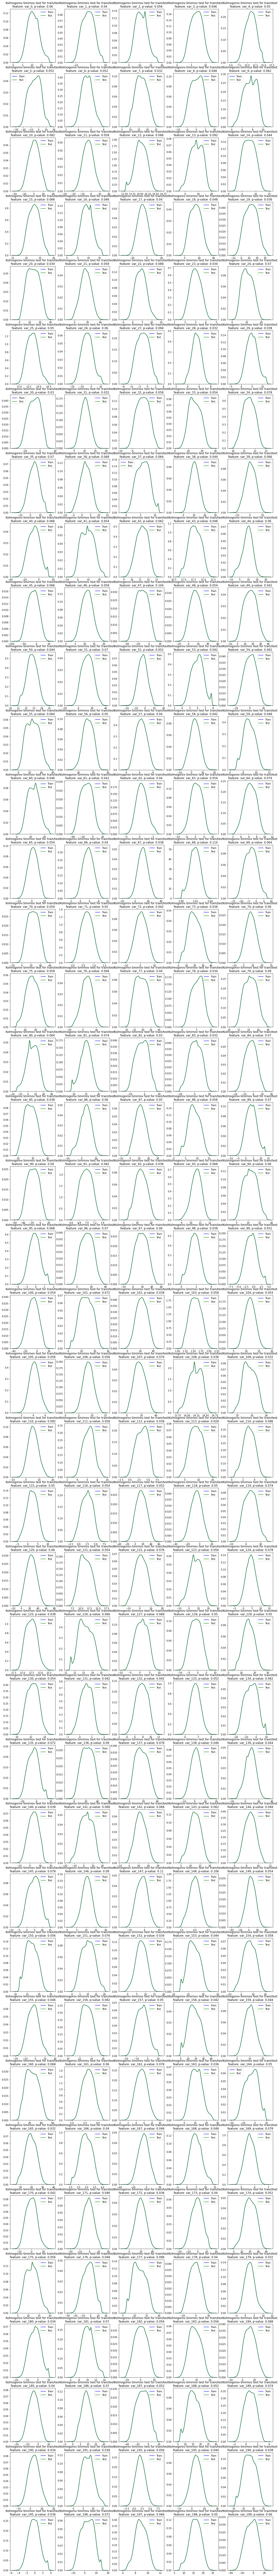

In [26]:
statistics_array = []
fig, axes = plt.subplots(40, 5, figsize=(20, 200))

for num, feature in enumerate(col):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

При уровне значимости p=0.05 не все выборки идентичны

In [27]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)
    

psi = PSI(threshold=0.01)

psi.fit_transform(
    X=train[col],
    y=test[col]
)

  0%|                                                  | 0/200 [00:00<?, ?it/s]<ipython-input-27-44fe82a59469>:141: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_score = np.sum(
100%|████████████████████████████████████████| 200/200 [00:15<00:00, 13.22it/s]


,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1
5,var_197,0.000168,1
6,var_36,0.000169,1
7,var_179,0.000179,1
8,var_71,0.000179,1
9,var_61,0.000183,1
